# Module Imports

In [153]:
from pyparsing import match_only_at_col
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xlsxwriter
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from datetime import date
from datetime import datetime
from datetime import timedelta
from PIL import Image

pd.set_option('display.max_rows', 4)

## Importing Data Analysis Functions For This Specific Project
- Functions from aoe2_functions folder/functions.py

In [165]:
from aoe2_functions.functions import api2df               #type:ignore
from aoe2_functions.functions import pathing              #type:ignore
from aoe2_functions.functions import png_cleaner          #type:ignore
# from aoe2_functions.functions import win_loss_fraction    #type:ignore
from aoe2_functions.functions import dataLabel_stacked    #type:ignore
from aoe2_functions.functions import xlsx_table_writer    #type:ignore
from aoe2_functions.functions import xlsx_chart           #type:ignore

# Function to Calculate Win Loss Percentages For Civilisations
def win_loss_fraction(table):
    # Adding additional column to calculate percentages
    empty_list = []
    for i in range(table.shape[0]):
        empty_list.append(0)
    table['Win%'] = empty_list
    table['Loss%'] = empty_list

    for i in range(table.shape[0]):
        win = table.iat[i,table.columns.get_loc('Win Count')]
        pick = table.iat[i,table.columns.get_loc('Pick Count')]
        win_perc = win/pick
        loss_perc = 1 - win_perc

        #Indexing into DataFrame
        table.iat[i,table.columns.get_loc('Win%')] = win_perc
        table.iat[i,table.columns.get_loc('Loss%')] = loss_perc

    #Dropping the 'won' == False because Win Count Column is only reflective of Wins
    table = table.loc[table['won'] == True]
    
    #Sorting DataFrame 
    table.sort_values(by='Win%',axis=0,ascending=False,kind='quicksort',inplace=True)

    return table

# Date Variables

In [ ]:
date_today = date.today()
date_today_unix = int(datetime.now().timestamp())
date_today_str = date_today.strftime("%d-%B-%Y")

# API Requests and Processing Data
### Civilisation Data

In [ ]:
#Address for Requesting Age of Empires 2 Leaderboard Data
data='strings'     #Return Keys For the Game String Data
requestAddr = f'https://aoe2.net/api/{data}?game=aoe2de'
dict = api2df(requestAddr)
df = pd.DataFrame.from_dict(dict,orient='index')

#Parsing the civilisation data into a dataframe
print('Generating Keys For Civilisation String Data')
dict = df.loc['civ',0]
df_civ = pd.DataFrame.from_dict(dict)

#Re-naming id column to merge civ data into other tables
df_civ.rename(columns={'id':'id_civ','string':'civilisation'},inplace=True)
# df_civ

Making API Call to: https://aoe2.net/api/strings?game=aoe2de
API Request Successful
Generating Keys For Civilisation String Data


### Leaderboard Data

In [ ]:
#Requesting Age of Empires 2 Leaderboard Data
data='leaderboard'
leaderboard_id = 3 #3 = Random Map Leaderboard
count = 100         #Extracting this many entries from table
count_leader_xlsx = count       #(for xlsxwriter title)
requestAddr = f'https://aoe2.net/api/{data}?game=aoe2de&leaderboard_id={leaderboard_id}&start=1&count={count}'
dict = api2df(requestAddr)
df = pd.DataFrame.from_dict(dict,orient='index')

#Parsing the leaderboard data into a dataframe
print(f'Generating Leaderboard History for the top {count} players')
dict = df.loc['leaderboard',0]
leaderboard = pd.DataFrame.from_dict(dict)

#Taking the Intersection of Column Headers and grabbing top 15 players
rating_top = leaderboard[leaderboard.columns.intersection(['steam_id','name','rating','country','games','wins','losses'])]
rating_top_xlsx = rating_top.copy()       #Preserving Table for xlsxwriter output
rating_top = rating_top.head(15)
rating_top = rating_top.iloc[::-1] #Flipping table upside down for purposes of plot data order

#Taking top and bottom ratings to form limits of graph axis
rat_top_ulim = rating_top.iat[0,rating_top.columns.get_loc('rating')]
rat_top_llim = rating_top.iat[rating_top.shape[0]-1,rating_top.columns.get_loc('rating')]
# rating_top
# leaderboard

Making API Call to: https://aoe2.net/api/leaderboard?game=aoe2de&leaderboard_id=3&start=1&count=100
API Request Successful
Generating Leaderboard History for the top 100 players


### Visualisation - Top Player Rating History

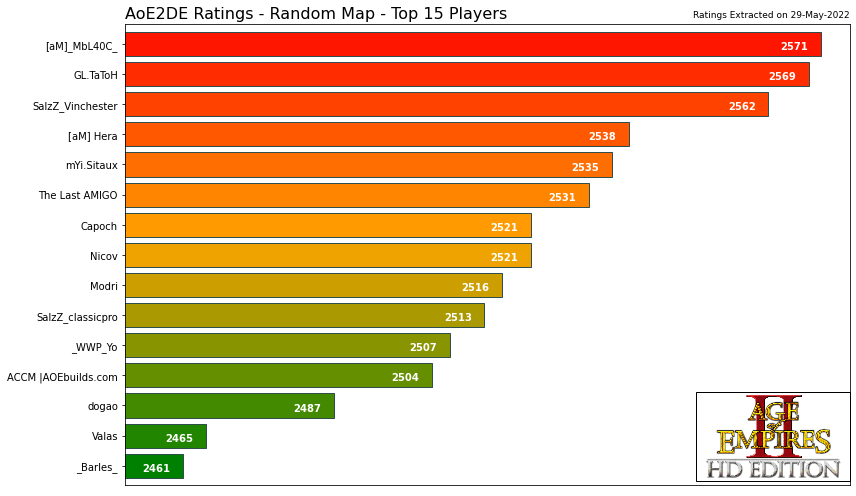

In [ ]:
#Plotting and Configuring Chart
#Making a colormap to map onto the bar chart
clist = [(0, "green"), (0.5, "orange"), (1, "red")]
rvb = mcolors.LinearSegmentedColormap.from_list('',clist)
df_arange = np.arange(rating_top.shape[0]).astype(float)
color =rvb(df_arange/rating_top.shape[0])

#Setting Axis Limits
lhs_axis_lim = rat_top_ulim - 10
rhs_axis_lim = rat_top_llim + 5

#Plotting a Leaderboard/Ratings Chart
fig, ax = plt.subplots(figsize=(12,7))
ax = rating_top.plot('name','rating',kind='barh',ax=ax,width=0.8,color=color,edgecolor='darkslategrey')
ax.set_title(f'AoE2DE Ratings - Random Map - Top 15 Players',loc='left',fontsize=16)
plt.text(rhs_axis_lim,14.9,f'Ratings Extracted on {date_today_str}',fontsize =9,horizontalalignment='right')

#Inserting AoE2 Logo on Existing Chart
filename = 'AoE2Logo.png'
folderpath = 'pictures'
filepath = pathing(folderpath,filename)
image = Image.open(filepath) #Reading Image Data
[width,height] = image.size
im_zoom = 0.15
imagebox = OffsetImage(image,zoom=im_zoom)
aoe2Logo = AnnotationBbox(imagebox 
                        ,[rhs_axis_lim,0],xybox=(-width*im_zoom,height*im_zoom/1.21)
                        , boxcoords='offset points', box_alignment=(0,1)
                        ,pad=0
                        )
ax.add_artist(aoe2Logo)

#Adjusting Plot Parameters
ax.get_legend().remove()
ax.set_ylabel('')
plt.xlim(lhs_axis_lim,rhs_axis_lim)
plt.xticks([])
plt.subplots_adjust(left=0.25) #adjusting plot to prevent y-tick cutoff
plt.tight_layout()

#----Data Labels-----
text_offset = 0.175 #Text Offset Distance
for i in range(rating_top.shape[0]):
    rating_value = rating_top.iat[i,rating_top.columns.get_loc('rating')]
    rating_pos = rating_value - 6.1
    if rating_value != 0:
        rating_value = int(rating_value)
        rating_pos = int(rating_pos)
        ax.text(rating_pos,i-text_offset,rating_value,fontsize=10,color='white',weight='bold')
#----Data Labels-----

#Saving Chart
fig_name = 'top15Players_leadboard.png'
folderpath = 'root'
fig_top15leadboard = pathing(folderpath,fig_name)
plt.savefig(fig_top15leadboard,dpi=100)

#-------------------------------------------------------------------------------------------------------------------------------------

### Top Player Rating History

In [ ]:
#Requesting Player Rating History
data = 'ratinghistory'  #Returning Rating Data
leaderboard_id = 3      #3 = Random Map Leaderboard
count = 1000             #Extracting this many entries from table
count_match_xlsx = count
top_player_id = rating_top.loc[0,'steam_id'] #Nesting the top player id from previous API call into the following request
top_player_name = rating_top.loc[0,'name']   #Grabbing name to place into chart title
requestAddr = f'https://aoe2.net/api/player/{data}?game=aoe2de&leaderboard_id={leaderboard_id}&steam_id={top_player_id}&count={count}'
dict = api2df(requestAddr)

#Parsing Player Rating History into Table
print(f'Generating Rating History for {top_player_name} over the last {count} games')
df_player_hist = pd.DataFrame.from_dict(dict,orient='columns')
df_player_hist['match_date'] = ''
df_player_hist['win_loss'] = ''

#Looping through DataFrame to prepare more data for analysis
for i in range(df_player_hist.shape[0]):

    #Since the timestamps are UNIX based, we need to convert them into DateTime Format so they are readable
    ts = df_player_hist.iat[i,df_player_hist.columns.get_loc('timestamp')]
    df_player_hist.iat[i,df_player_hist.columns.get_loc('match_date')] = datetime.fromtimestamp(ts)

    #Determine if match was a win or a loss (represented by an W or L string)
    i_b = i+1 #Create index value for match b to grab previous match
    if i_b != df_player_hist.shape[0]:

        match_a = df_player_hist.iat[i,df_player_hist.columns.get_loc('num_wins')]
        match_b = df_player_hist.iat[i_b,df_player_hist.columns.get_loc('num_wins')]

        if match_a > match_b:
            df_player_hist.iat[i,df_player_hist.columns.get_loc('win_loss')] = 'W'
        else:
            df_player_hist.iat[i,df_player_hist.columns.get_loc('win_loss')] = 'L'

    #Can't determine a win/loss for the final iteration so we have to drop the last row
    else:
        df_player_hist = df_player_hist[:-1]
    
#Determining the month with most matches played to form as axis ylimit
match_y_lim = df_player_hist.groupby(['match_date'])['match_date'].count()
match_y_lim = match_y_lim.groupby([pd.Grouper(level='match_date',freq='1M')]).sum().reset_index(name='Match Count')
match_y_lim.sort_values(by='Match Count',axis=0,ascending=False,kind='quicksort',inplace=True)
match_y_lim = match_y_lim.iat[0,1]

#Performing Groupby Operation To Determine Monthly Statistics
df_player_hist = df_player_hist.groupby(['match_date','win_loss'])['win_loss'].count()
df_player_hist = df_player_hist.groupby([pd.Grouper(level='match_date',freq='1M'),'win_loss']).sum().unstack('win_loss')
df_player_hist.index = pd.to_datetime(df_player_hist.index).strftime('%b-%y')
df_player_hist

Making API Call to: https://aoe2.net/api/player/ratinghistory?game=aoe2de&leaderboard_id=3&steam_id=76561197996386232&count=1000
API Request Successful
Generating Rating History for [aM]_MbL40C_ over the last 1000 games


win_loss,L,W
match_date,,
Dec-20,9,22
Jan-21,23,52
...,...,...
Apr-22,15,48
May-22,35,108


### Visualisation - Top Player Match History

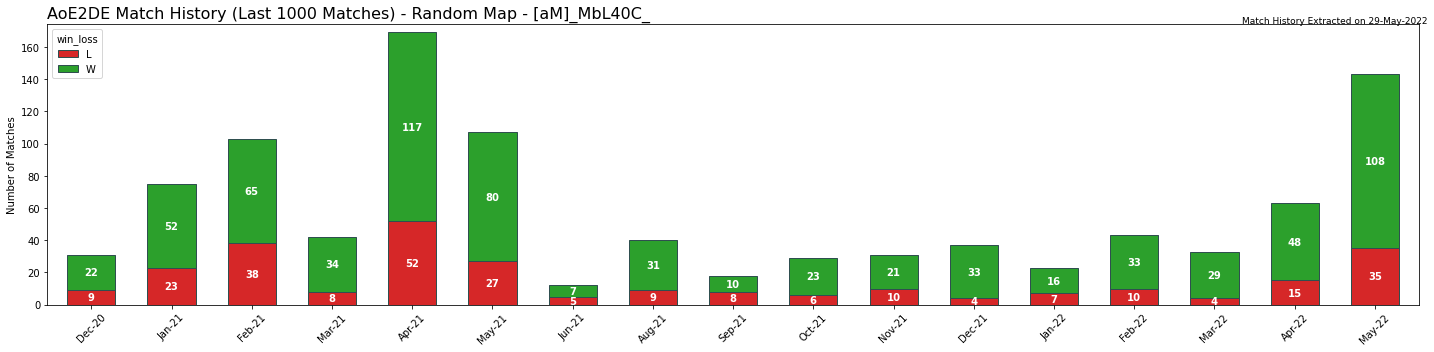

In [ ]:
#Plotting a Player History Chart
upper_ylim = match_y_lim + 5 #Setting upper bound of y-axis

fig, ax = plt.subplots(figsize=(20,5))
ax = df_player_hist.plot(kind='bar',ax=ax,width=0.6,edgecolor='darkslategrey',color=['tab:red','tab:green'],stacked=True)
ax.set_title(f'AoE2DE Match History (Last {count_match_xlsx} Matches) - Random Map - {top_player_name}',loc='left',fontsize=16)
plt.text(df_player_hist.shape[0]-0.35,upper_ylim+1,f'Match History Extracted on {date_today_str}',fontsize =9,horizontalalignment='right')
ax.set_ylabel('Number of Matches', fontsize=10)
ax.set_xlabel('')
ax.tick_params(axis='x',labelrotation=45,labelsize=10)
plt.ylim(0,upper_ylim) #Setting y-lim
plt.tight_layout()

#Annotations
text_offset = 2
text_format = 'integer'
fontsize = 10
col_val_list = ['L','W']
dataLabel_stacked(df_player_hist,col_val_list,text_offset,text_format,fontsize,ax)

#Saving Chart
fig_name = 'topPlayer_MatchHistory.png'
folderpath = 'root'
fig_topPlayerMatchHist = pathing(folderpath,fig_name)
plt.savefig(fig_topPlayerMatchHist,dpi=100)


### Player Match History

In [ ]:
#Requesting Top Player Match History
data = 'matches'        #Returning Match Data
leaderboard_id = 3      #3 = Random Map Leaderboard
count = count_match_xlsx       #(for xlsxwriter title)
since = date_today_unix #Extracting Match History From This Date
player_id = rating_top.loc[0,'steam_id'] #Nesting the top player id from previous API call into the following request
top_player_name = rating_top.loc[0,'name']   #Grabbing name to place into chart title
requestAddr = f'https://aoe2.net/api/player/{data}?game=aoe2de&leaderboard_id={leaderboard_id}&steam_id={top_player_id}&count={count}&since={since}'
dict = api2df(requestAddr)
print(f'Generating Match History For {top_player_name} over the last {count} games')

Making API Call to: https://aoe2.net/api/player/matches?game=aoe2de&leaderboard_id=3&steam_id=76561197996386232&count=1000&since=1653781426
API Request Successful
Generating Match History For [aM]_MbL40C_ over the last 1000 games


### Function For Extracting Match History

In [ ]:
def player_match_history(since,player_id):

    #Calling API For Data
    count = 1000
    requestAddr = f'https://aoe2.net/api/player/{data}?game=aoe2de&leaderboard_id={leaderboard_id}&steam_id={player_id}&count={count}&since={since}'
    dict = api2df(requestAddr)

    #Parsing Player Match History into Table
    df = pd.DataFrame.from_dict(dict,orient='columns')
    match_list = [] #Initialise empty list
    for i in range(df.shape[0]):
        #Each dict inside the iterable list corresponds to a player in any given match_id
        match_id = {'match_id':df.loc[i,'match_id'],'finished':df.loc[i,'finished']}
        i_player_match = df.loc[i,'players']
        #This nested loop appends all the player data to a list
        for j in range(len(i_player_match)):
            i_player_match[j].update(match_id)
            match_list.append(i_player_match[j])
    
    #Transforming the List of dictionaries into a dataframe with the Top Player vs Opponents
    df_player_matches = pd.json_normalize(match_list)

    #Renaming civ col to id_civ to be used as a key for merging in civilisation data
    df_player_matches.rename(columns={'civ':'id_civ'},inplace=True)
    #Merging in Civilisation Data
    df_player_matches = pd.merge(df_player_matches,df_civ,how='left')
    #Filtering rating_change to non-NaN
    df_player_matches = df_player_matches.loc[df_player_matches['rating_change'].isnull() == False]

    #Oldest Date In This DataFrame
    # since = df_player_matches['finished'].min

    return df_player_matches

### Top Player Match History

In [ ]:
#Adding Extra Column to the Table and Determine if player is the opponent
df_player_matches = player_match_history(since,player_id)
df_player_matches['player'] = ''
for i in range (df_player_matches.shape[0]):
    if df_player_matches.iat[i,df_player_matches.columns.get_loc('name')] == top_player_name:
        df_player_matches.iat[i,df_player_matches.columns.get_loc('player')] = top_player_name
    else:
        df_player_matches.iat[i,df_player_matches.columns.get_loc('player')] = 'enemy'

#Re-arranging DataFrame to Move The Match_id to the front of the table
move_column = df_player_matches.pop('match_id')
df_player_matches.insert(0,move_column.name,move_column)

df_player_matches

Making API Call to: https://aoe2.net/api/player/matches?game=aoe2de&leaderboard_id=3&steam_id=76561197996386232&count=1000&since=1653781426
API Request Successful


,match_id,profile_id,steam_id,name,clan,country,slot,slot_type,rating,rating_change,...,streak,drops,color,team,id_civ,civ_alpha,won,finished,civilisation,player
0,162038928,196310,76561198275970890,[KGB] F1Re,None,BR,1,1,2431.0,-4.0,...,None,None,2,1,26,27,False,1653783716,Malians,enemy
1,162038928,251265,76561197996386232,[aM]_MbL40C_,None,NO,2,1,2576.0,4.0,...,None,None,1,2,28,22,True,1653783716,Khmer,[aM]_MbL40C_
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2815,39689445,2921459,76561199070001626,Xtreme | Tuco,None,BR,8,1,2130.0,0.0,...,None,None,1,2,6,7,False,1600644942,Chinese,enemy
2832,32994257,1879755,76561198323710321,g.mouratidis,None,GR,1,1,979.0,0.0,...,None,None,2,1,5,16,False,1596750750,Japanese,enemy


## Recursively Calling API for top 100 player match data
- Count number for matches limited to 1000 
- ~~Retrieving oldest date, and receycling back into future API calls~~
- Retrieving Each Steam ID From the Leader Board And Pulling Data Together
- Each API match request is appended into a single dataframe

In [ ]:
#Requesting Top Player Match History
data = 'matches'        #Returning Match Data
leaderboard_id = 3      #3 = Random Map Leaderboard
count = 15              #Extracting this many entries from table
count_all_matches = count #For xlsxwriter
since = date_today_unix           #Extracting Match History From This Date

print(f'Generating data of all the ranked games played for the top {count_leader_xlsx} players')

for k in range(10): 
    player_id = rating_top.loc[k,'steam_id'] #Nesting the top player id from previous API call into the following request
    player_name = rating_top.loc[k,'name']   #Grabbing name to place into chart title
    print(f'Grabbing matches for {player_name} {player_id}')
    df_match_batch = player_match_history(since,player_id)
    if k > 0:
        df_all_matches = pd.concat([df_all_matches,df_match_batch])
    else:
        df_all_matches = df_match_batch


Generating data of all the ranked games played for the top 100 players
Grabbing matches for [aM]_MbL40C_ 76561197996386232
Making API Call to: https://aoe2.net/api/player/matches?game=aoe2de&leaderboard_id=3&steam_id=76561197996386232&count=1000&since=1653781426
API Request Successful
Grabbing matches for GL.TaToH 76561198088251629
Making API Call to: https://aoe2.net/api/player/matches?game=aoe2de&leaderboard_id=3&steam_id=76561198088251629&count=1000&since=1653781426
API Request Successful
Grabbing matches for SalzZ_Vinchester 76561198000635167
Making API Call to: https://aoe2.net/api/player/matches?game=aoe2de&leaderboard_id=3&steam_id=76561198000635167&count=1000&since=1653781426
API Request Successful
Grabbing matches for [aM] Hera 76561198449406083
Making API Call to: https://aoe2.net/api/player/matches?game=aoe2de&leaderboard_id=3&steam_id=76561198449406083&count=1000&since=1653781426
API Request Successful
Grabbing matches for mYi.Sitaux 76561198116921964
Making API Call to: ht

In [166]:
#We must drop duplicate match_id's to avoid double counting the data
df_copy = df_all_matches.copy()
#Need drop match_id duplicates, however we still need to keep all the players that played on the same ID (such that we are not left with 1 player)
df_all_matches.drop_duplicates(subset=['match_id','steam_id'],inplace=True)
df_all_matches

,profile_id,steam_id,name,clan,country,slot,slot_type,rating,rating_change,games,...,streak,drops,color,team,id_civ,civ_alpha,won,match_id,finished,civilisation
0,196310.0,76561198275970890,[KGB] F1Re,None,BR,1,1,2427.0,-4.0,None,...,None,None,2.0,1.0,25.0,13.0,False,162042800,1.653786e+09,Ethiopians
1,251265.0,76561197996386232,[aM]_MbL40C_,None,NO,2,1,2580.0,4.0,None,...,None,None,1.0,2.0,28.0,22.0,True,162042800,1.653786e+09,Khmer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998,746777.0,76561198401970946,nanimaren,None,DE,7,1,2510.0,12.0,None,...,None,None,6.0,1.0,26.0,22.0,True,44646241,1.603389e+09,Malians
1999,1843149.0,76561198201475421,yanki,None,TR,8,1,2699.0,-2.0,None,...,None,None,7.0,2.0,13.0,6.0,False,44646241,1.603389e+09,Celts


In [167]:

df_all_matches_civ_pickrate = df_all_matches.groupby(['civilisation'])['civilisation'].count().reset_index(name='Pick Count')
df_all_matches_civ_winrate = df_all_matches.groupby(['civilisation','won'])['civilisation'].count().reset_index(name='Win Count')
df_all_matches_civ_winrate = pd.merge(df_all_matches_civ_winrate,df_all_matches_civ_pickrate,how='left')
df_all_matches_civ_winrate


,civilisation,won,Win Count,Pick Count
0,Aztecs,False,53,120
1,Aztecs,True,67,120
...,...,...,...,...
84,Vikings,False,73,151
85,Vikings,True,78,151


In [168]:
df_all_matches_civ_winrate = win_loss_fraction(df_all_matches_civ_winrate)
df_all_matches_civ_winrate

C:\Users\Filip\AppData\Local\Temp\ipykernel_20868\2196876020.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.sort_values(by='Win%',axis=0,ascending=False,kind='quicksort',inplace=True)


,civilisation,won,Win Count,Pick Count,Win%,Loss%
35,Hindustanis,True,38,62,0.612903,0.387097
39,Incas,True,62,104,0.596154,0.403846
...,...,...,...,...,...,...
25,Dravidians,True,31,74,0.418919,0.581081
59,Mayans,True,93,222,0.418919,0.581081


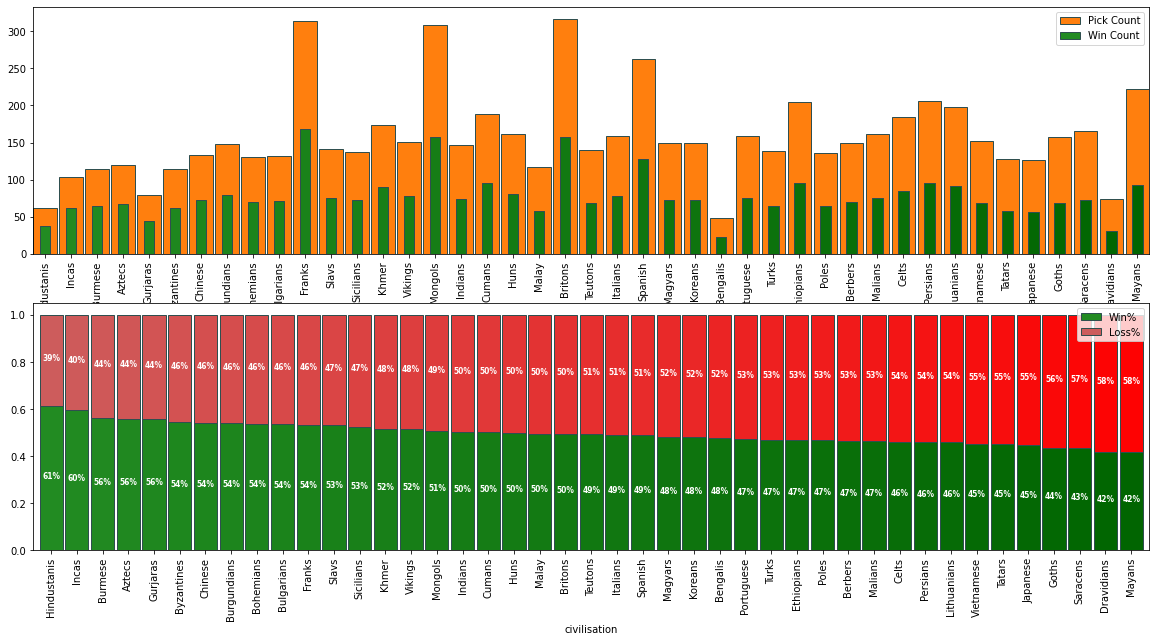

In [178]:
#Making a colormap to map onto the bar chart
#Win
clist = [(0, 'forestgreen'), (1, 'darkgreen')]
rvb = mcolors.LinearSegmentedColormap.from_list('',clist)
df_arange = np.arange(df_all_matches_civ_winrate.shape[0]).astype(float)
color_win =rvb(df_arange/df_all_matches_civ_winrate.shape[0])

#Lose
clist = [(0, 'indianred'), (1, 'red')]
rvb = mcolors.LinearSegmentedColormap.from_list('',clist)
df_arange = np.arange(df_all_matches_civ_winrate.shape[0]).astype(float)
color_lose =rvb(df_arange/df_all_matches_civ_winrate.shape[0])


df_all_matches_civ_winrate
fig, ax = plt.subplots(figsize=(20,10),nrows=2,ncols=1)

ax[0] = df_all_matches_civ_winrate.plot(y='Pick Count',x='civilisation',kind='bar',ax=ax[0],width=0.9,edgecolor='darkslategrey',color='tab:orange')
ax[0] = df_all_matches_civ_winrate.plot(y='Win Count',x='civilisation',kind='bar',ax=ax[0],width=0.4,edgecolor='darkslategrey',color=color_win)
# ax [0]= df_all_matches_civ_winrate.plot(y='Loss%',x='civilisation',kind='bar',ax=ax[0],width=0.9,edgecolor='darkslategrey',color=color_lose,bottom = df_all_matches_civ_winrate['Win%'])

ax[1] = df_all_matches_civ_winrate.plot(y='Win%',x='civilisation',kind='bar',ax=ax[1],width=0.9,edgecolor='darkslategrey',color=color_win)
ax [1]= df_all_matches_civ_winrate.plot(y='Loss%',x='civilisation',kind='bar',ax=ax[1],width=0.9,edgecolor='darkslategrey',color=color_lose,bottom = df_all_matches_civ_winrate['Win%'])

#Annotations
text_offset =0
text_format = 'percentage'
fontsize = 7.5
col_val_list = ['Win%','Loss%']
dataLabel_stacked(df_all_matches_civ_winrate,col_val_list,text_offset,text_format,fontsize,ax[1])

#Saving Chart
fig_name = 'AllMatches_civWinrate.png'
folderpath = 'root'
fig_topCivWinRate = pathing(folderpath,fig_name)
plt.savefig(fig_topCivWinRate,dpi=100)

### Grouping Top 1 Player Civilisation Win Loss Percentage (Ranked Only)

In [170]:
#Grouping Top Player Civ Pick and Win Rate
df_topplayer_civ_pickrate = df_player_matches.groupby(['civilisation','player'])['civilisation'].count().reset_index(name='Pick Count')
df_topplayer_civ_pickrate = df_topplayer_civ_pickrate.loc[((df_topplayer_civ_pickrate['player'] != 'enemy'))]
df_topplayer_civ_pickrate.drop(columns='player',inplace=True)
df_topplayer_civ_pickrate.fillna(0,inplace=True)
df_topplayer_civ_pickrate = df_topplayer_civ_pickrate.reset_index().drop(columns='index')

df_topplayer_civ_winrate = df_player_matches.groupby(['civilisation','player','won'])['civilisation'].count().reset_index(name='Win Count')
df_topplayer_civ_winrate = df_topplayer_civ_winrate.loc[((df_topplayer_civ_winrate['player'] != 'enemy'))]
df_topplayer_civ_winrate.drop(columns='player',inplace=True)
df_topplayer_civ_winrate.fillna(0,inplace=True)
df_topplayer_civ_winrate = df_topplayer_civ_winrate.reset_index().drop(columns='index')

#Merging winrate with pick rate
df_topplayer_civ_winrate = pd.merge(df_topplayer_civ_winrate,df_topplayer_civ_pickrate,how='left')

#Applying function to calculate percentages
df_topplayer_civ_winrate = win_loss_fraction(df_topplayer_civ_winrate)

df_topplayer_civ_winrate



C:\Users\Filip\AppData\Local\Temp\ipykernel_20868\2196876020.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.sort_values(by='Win%',axis=0,ascending=False,kind='quicksort',inplace=True)


,civilisation,won,Win Count,Pick Count,Win%,Loss%
34,Italians,True,5,5,1.0,0.0
26,Goths,True,5,5,1.0,0.0
...,...,...,...,...,...,...
58,Saracens,True,2,4,0.5,0.5
21,Dravidians,True,2,4,0.5,0.5


### Visualisation - Top Player Ranked Wins (Grouped by Civ)

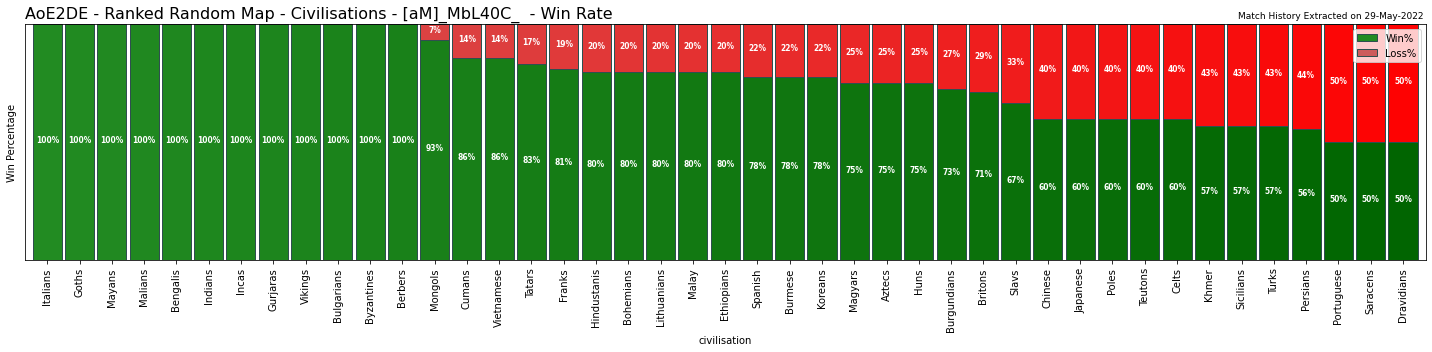

In [171]:
#Making a colormap to map onto the bar chart
#Win
clist = [(0, 'forestgreen'), (1, 'darkgreen')]
rvb = mcolors.LinearSegmentedColormap.from_list('',clist)
df_arange = np.arange(df_topplayer_civ_winrate.shape[0]).astype(float)
color_win =rvb(df_arange/df_topplayer_civ_winrate.shape[0])

#Lose
clist = [(0, 'indianred'), (1, 'red')]
rvb = mcolors.LinearSegmentedColormap.from_list('',clist)
df_arange = np.arange(df_topplayer_civ_winrate.shape[0]).astype(float)
color_lose =rvb(df_arange/df_topplayer_civ_winrate.shape[0])

fig, ax = plt.subplots(figsize=(20,5))
ax = df_topplayer_civ_winrate.plot(y='Win%',x='civilisation',kind='bar',ax=ax,width=0.9,edgecolor='darkslategrey',color=color_win)
ax = df_topplayer_civ_winrate.plot(y='Loss%',x='civilisation',kind='bar',ax=ax,width=0.9,edgecolor='darkslategrey',color=color_lose,bottom = df_topplayer_civ_winrate['Win%'])
ax.set_title(f'AoE2DE - Ranked Random Map - Civilisations - {top_player_name}  - Win Rate',loc='left',fontsize=16)
plt.text(df_topplayer_civ_winrate.shape[0]-0.35,1.025,f'Match History Extracted on {date_today_str}',fontsize =9,horizontalalignment='right')
ax.set_ylabel('Win Percentage', fontsize=10)
plt.yticks([])
plt.tight_layout()

#Annotations
text_offset =0
text_format = 'percentage'
fontsize = 7.5
col_val_list = ['Win%','Loss%']
dataLabel_stacked(df_topplayer_civ_winrate,col_val_list,text_offset,text_format,fontsize,ax)

#Saving Chart
fig_name = 'topPlayer_civWinrate.png'
folderpath = 'root'
fig_topCivWinRate = pathing(folderpath,fig_name)
plt.savefig(fig_topCivWinRate,dpi=100)


### Exporting Match History Using Xlsxwriter and Formatting Excel Workbook
#### Initialising Workbook Instance

In [ ]:
#----------------------------------------------------------------------------------------------------------------------
#--------------------------------------------.xlsx workbook initialisation---------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

#Excel Output Filename
filename = 'AoE2_tabular.xlsx'
folderpath = 'root'
excelpath = pathing(folderpath,filename)

#Generating .xlsx workbook in which to record dataframes for usage.
writer = pd.ExcelWriter(excelpath,engine='xlsxwriter')   
workbook=writer.book
worksheet='' #Initialise variable
startrow = 0 #Initialise variable
startcol = 0 #Initialise variable

#Looping through the list of countries to chart all the data per country
v_idx = 0       #initialise counter to index vertical chart insertions
lr_pos = 0      #initialise left right insertion variable

#----------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

### Entering Inputs For Selected Worksheet and Running Function Over Tables

In [ ]:
#Leadboard Table
data_table = rating_top_xlsx
sheet_name = 'leaderboard'
title_str = f'Leaderboard History for the top {count_leader_xlsx} players'
col_width_list = [6,25,25,10,10,10,10]
[startrow,startcol,worksheet,workbook,writer] = xlsx_table_writer(data_table,sheet_name,col_width_list,title_str,startrow,startcol,worksheet,workbook,writer)

#Top 1 Player Ranked Match History Details
data_table = df_player_matches
sheet_name = 'match_data'
title_str = f'{top_player_name} Match History over the last {count_match_xlsx} games'
col_width_list = [15,15,23,23,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,23,15,15,15]
[startrow,startcol,worksheet,workbook,writer] = xlsx_table_writer(data_table,sheet_name,col_width_list,title_str,startrow,startcol,worksheet,workbook,writer)

### Collating All Charts And Inserting Into Excel Workbook

In [ ]:
#Leaderboard Charts
sheet_name = 'leaderboard_charts'
chart_path = fig_top15leadboard
v_space = 25
[v_idx,sheet_name,worksheet] = xlsx_chart(v_idx,v_space,chart_path,sheet_name,worksheet,workbook,writer)

#Charts For The Top 1 Player
sheet_name = 'top_player_charts'
v_idx = 0       #Re-initialise variable to reset first position for new sheet
chart_path = fig_topPlayerMatchHist
v_space = 25
[v_idx,sheet_name,worksheet] = xlsx_chart(v_idx,v_space,chart_path,sheet_name,worksheet,workbook,writer)

chart_path = fig_topCivWinRate
v_space = 25
[v_idx,sheet_name,worksheet] = xlsx_chart(v_idx,v_space,chart_path,sheet_name,worksheet,workbook,writer)

In [ ]:
#Save into Excel and Exit Python out of File
writer.close()

### File Clean-up - Deleting All .png's from directory

In [ ]:
# png_cleaner()